### Computing autocorrelation time

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import importlib
# import ising_analysis
# importlib.reload(ising_analysis)

In [75]:
# Set parameters
a,b,c = 0.30,10,1

In [76]:
# Load correlated Monte Carlo data
data_correlated_rejection = np.loadtxt("./data/%.6f_%.6f_%.6f_simpleTruncexpon_rejection.dat"%(a,b,c))[20000:]
data_correlated_direct = np.loadtxt("./data/%.6f_%.6f_%.6f_simpleTruncexpon_direct.dat"%(a,b,c))[20000:]

MC_steps = np.arange(data_correlated_rejection.shape[0])

#### As part of our computation of the integrated autocorrelation time, we will need to compute the normalized autocorrelation function:

$$ \rho(t) = \frac{c(t)}{c(0)} = \frac{\frac{1}{N-t}\sum_{i=1}^{N-t}{X_{i}X_{i+t}-{\left\langle{X}\right\rangle^2}}}{\left\langle{X^2}\right\rangle-{\left\langle{X}\right\rangle^2}} \sim e^{-\frac{t}{\tau_\mathrm{exp}}} $$

In [77]:
def autocorrelation(data):
    '''Computes normalized autocorrelation function of sample data for each time'''
    N = data.shape[0]
    _autocorrelation = np.zeros(N)
    for Δt in range(N-1): # let the time separation be all possible distances
        c0 = np.mean(data[:N - Δt]**2) - np.mean(data[:N - Δt])**2 #Variance at t0
        ct = np.mean(data[:N - Δt]*data[Δt:]) - np.mean(data[:N - Δt])*np.mean(data[Δt:]) # unnormalized autocorrelation fn.
        _autocorrelation[Δt] = ct/c0 # normalized autocorrelation function for this 'radius' (actually time separation)
    return _autocorrelation

def autocorrelation_function(time,scale,autocorrelation_time):
    '''exponential form of the autocorrelation function'''
    return scale*np.exp(-time/autocorrelation_time)

In [78]:
# Compute normalized autocorrelation function
_autocorrelation_rejection = autocorrelation(data_correlated_rejection)
_autocorrelation_direct = autocorrelation(data_correlated_direct)

# Eliminate nans (there's usually just a few)
_autocorrelation_rejection = np.ma.masked_array(_autocorrelation_rejection, ~np.isfinite(_autocorrelation_rejection)).filled(0)
_autocorrelation_direct = np.ma.masked_array(_autocorrelation_direct, ~np.isfinite(_autocorrelation_direct)).filled(0)

# Time separations
time_separation = np.arange(_autocorrelation_rejection.shape[0])

<ipython-input-77-3fa33d3506a9>:8: RuntimeWarning: invalid value encountered in double_scalars
  _autocorrelation[Δt] = ct/c0 # normalized autocorrelation function for this 'radius' (actually time separation)


In [79]:
# Fit autocorrelation to exponential form for all time separations
popt_rejection, perr_rejection = curve_fit(autocorrelation_function, time_separation, _autocorrelation_rejection)
popt_direct, perr_direct = curve_fit(autocorrelation_function, time_separation, _autocorrelation_direct)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


#### The integrated autocorrelation is obtained by summing the autocorrelation function over all possible time separations:

$$ \tau_\mathrm{int}=\sum_t \frac{C(t)}{C(0)}$$

In [80]:
def integrated_autocorrelation_time(data):
    data_mean_squared = np.mean(data)**2
    variance = np.mean(data**2) - data_mean_squared # c(0)
    τ_int_auto = 0.0
    N = data.shape[0]
    for Δt in range(N):
#         τ_int_auto += np.mean(data[:N - Δt]*data[Δt:]) - data_mean_squared
        τ_int_auto += np.mean(data[:N - Δt]*data[Δt:]) - np.mean(data[:N - Δt])*np.mean(data[Δt:])
    return τ_int_auto/variance

In [81]:
def integrated_autocorrelation_time(data):
    data_mean_squared = np.mean(data)**2
    variance = np.mean(data**2) - data_mean_squared # c(0)
    τ_int_auto = 0.0
    N = data.shape[0]
    for Δt in range(N):
#         τ_int_auto += np.mean(data[:N - Δt]*data[Δt:]) - data_mean_squared
        τ_int_auto += np.mean(data[:N - Δt]*data[Δt:]) - np.mean(data[:N - Δt])*np.mean(data[Δt:])
    return τ_int_auto/variance

In [82]:
# autocorrelation_time_int = integrated_autocorrelation_time(data_correlated_rejection) # I think we need to truncate this

#### We can obtain the autocorrelation time from a fitting of: $$Ae^{-t/\tau_{exp}}$$

In [83]:
print("τ_auto: {}".format(popt_rejection[1])) # from fitting
print("4τ_auto: {}".format(4*popt_rejection[1]))
print("\n")
print("τ_auto: {}".format(popt_direct[1])) # from fitting
print("4τ_auto: {}".format(4*popt_direct[1]))

# print("τ_auto_int: {}".format(autocorrelation_time_int)) # from using estimate
# print("τ_exact: {}".format(autocorrelation_time))

τ_auto: 8.92362533939674
4τ_auto: 35.69450135758696


τ_auto: 0.02871424707271096
4τ_auto: 0.11485698829084384


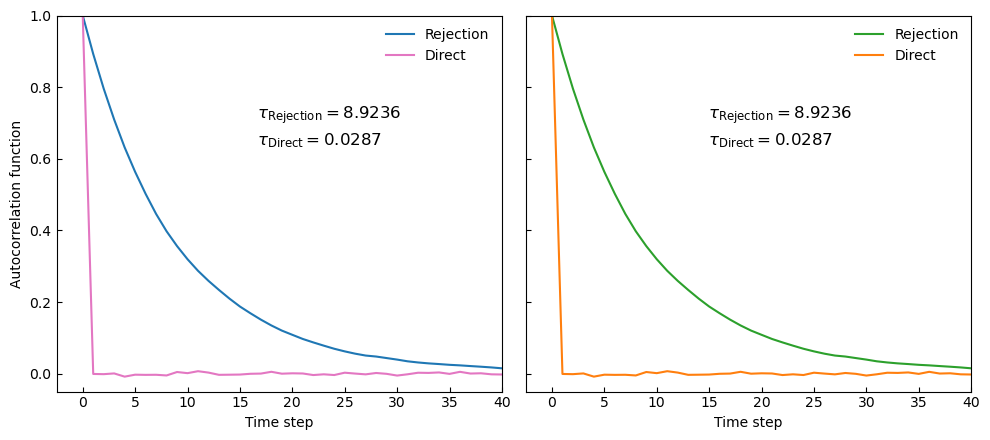

In [84]:
fig,ax = plt.subplots(1,2,figsize=(10,4.5), dpi=100,sharey=True,tight_layout=True)
plt.subplots_adjust(wspace=0.02)
ax[0].plot(time_separation, _autocorrelation_rejection,'-',color='tab:blue',label='Rejection') # autocorrelation function
ax[0].plot(time_separation, _autocorrelation_direct,'-',color='tab:pink',label='Direct') # autocorrelation function

ax[0].set_xlim((-2.5,40))
ax[0].set_ylim(-0.05,1)
ax[0].set_yscale('linear')
ax[0].set_ylabel(r'Autocorrelation function');
ax[0].set_xlabel(r'Time step');
ax[0].tick_params(direction='in')
ax[0].legend(frameon=False)
ax[0].annotate(r"$\tau_{\rm{Rejection}}=%.4f$"%(popt_rejection[1]),(0.20+0.06,0.58+0.15),
                xycoords='figure fraction',fontsize=12)
ax[0].annotate(r"$\tau_{\rm{Direct}}=%.4f$"%(popt_direct[1]),(0.20+0.06,0.58+0.09),
                xycoords='figure fraction',fontsize=12)

ax[1].plot(time_separation, _autocorrelation_rejection,'-',color='tab:green',label='Rejection') # autocorrelation function
ax[1].plot(time_separation, _autocorrelation_direct,'-',color='tab:orange',label='Direct') # autocorrelation function

ax[1].set_xlim((-2.5,40))
ax[1].set_ylim(-0.05,1)
ax[1].set_yscale('linear')
ax[1].set_ylabel(r'');
ax[1].set_xlabel(r'Time step');
ax[1].tick_params(direction='in')
ax[1].legend(frameon=False)
ax[1].annotate(r"$\tau_{\rm{Rejection}}=%.4f$"%(popt_rejection[1]),(0.655+0.06,0.58+0.15),
                xycoords='figure fraction',fontsize=12)
ax[1].annotate(r"$\tau_{\rm{Direct}}=%.4f$"%(popt_direct[1]),(0.655+0.06,0.58+0.09),
                xycoords='figure fraction',fontsize=12)

# plt.savefig("act_comparison_T4.00_mc_rbm_combined.pdf",dpi=300)
# plt.savefig("act_comparison_T4.00_mc_rbm_combined.png",dpi=300)

plt.show()

In [85]:
popt_rejection[1]/popt_direct[1]

310.7734399860844